In [4]:
import photutils, astropy
from photutils import datasets
from astropy.modeling.functional_models import Sersic2D

import numpy
import matplotlib.pyplot as plt

from astropy import visualization, convolution, stats

from collections import OrderedDict

In [34]:
#model = Sersic2D(amplitude = 3, r_eff = 25, n=4, x_0=50, y_0=50,
#               ellip=.5, theta=-1)

model = Sersic2D()
n_sources = 200
shape = (2000, 2000)
param_ranges = [('amplitude', [100, 200]),
                ('r_eff', [5, 35]),
                ('x_0', [0, shape[1]]),
                ('y_0', [0, shape[0]]),
                ('n', [0.8, 4]),
                ('ellip', [0, 5]),
                ('theta', [-2, 2])]
param_ranges = OrderedDict(param_ranges)
sources = datasets.make_random_models_table(n_sources, param_ranges,
                                   random_state=12345)
data = datasets.make_model_sources_image(shape, model, sources)

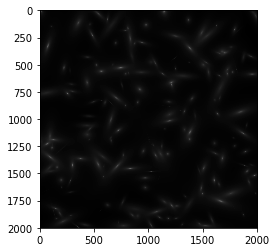

In [35]:
norm = visualization.mpl_normalize.ImageNormalize(
    stretch=visualization.SqrtStretch())

#plt.imshow(data)
plt.imshow(data, cmap='Greys_r', norm=norm)